In [1]:
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox

### 1. Generate network nodes and edges

In [2]:
ox.config(use_cache=True, log_console=True)

In [3]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'}

In [4]:
counties_shapefile_zip = counties_shapefile_url[counties_shapefile_url.rfind('/') + 1 :]
counties_shapefile_dir = counties_shapefile_zip[: counties_shapefile_zip.rfind('.zip')]
if not os.path.exists(counties_shapefile_dir):
    response = requests.get(counties_shapefile_url)
    with open(counties_shapefile_zip, 'wb') as f:
        f.write(response.content)
        with zipfile.ZipFile(counties_shapefile_zip, 'r') as zip_file:
            zip_file.extractall(counties_shapefile_dir)
    os.remove(counties_shapefile_zip)

In [5]:
counties = gpd.read_file(counties_shapefile_dir)
len(counties)

3233

In [6]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

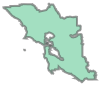

In [7]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon

In [8]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon = bayarea_polygon.convex_hull
bayarea_polygon_proj, crs = ox.project_geometry(bayarea_polygon)

In [9]:
# do not simplify yet, we'll strip out unwanted local streets first
G = ox.graph_from_polygon(bayarea_polygon, network_type='all', simplify=True)

In [10]:
print(len(G.nodes()))
print(len(G.edges()))

632747
1653440


In [11]:
ox.save_graphml(G)

In [12]:
ox.save_graph_shapefile(G, folder='shape')

/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/geopandas/io/file.py:62: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [13]:
nodes, edges = ox.graph_to_gdfs(G, node_geometry=False, fill_edge_geometry=False)

ecols = ['u', 'v', 'oneway', 'highway', 'name',
         'lanes', 'maxspeed']

edges = edges.drop(columns=['geometry']).reindex(columns=ecols)
nodes = nodes.reindex(columns=['osmid', 'x', 'y', 'highway'])

In [16]:
edges.head()

,u,v,oneway,highway,name,lanes,maxspeed
0,5125439488,5436098947,False,footway,NaN,NaN,NaN
1,5125439488,5436093519,False,footway,NaN,NaN,NaN
2,5125439488,5436098941,False,footway,NaN,NaN,NaN
3,5125439509,4730162396,False,footway,NaN,NaN,NaN
4,5125439509,5125436062,False,footway,NaN,NaN,NaN


In [17]:
nodes.head()

,osmid,x,y,highway
5125439488,5125439488,-121.959718,37.412849,NaN
5125439509,5125439509,-121.956345,37.412470,NaN
5125439527,5125439527,-121.958650,37.414199,NaN
5125439538,5125439538,-121.957658,37.413890,NaN
5398069319,5398069319,-121.678608,37.724694,NaN


In [19]:
nodes.to_csv('data/bay_area_full_nodes.csv', index=False, encoding='utf-8')
edges.to_csv('data/bay_area_full_edges.csv', index=False, encoding='utf-8')

### 2. Open nodes and edges and convert to OSM XML

In [95]:
nodes = pd.read_csv('./data/bay_area_full_nodes.csv')
edges = pd.read_csv('./data/bay_area_full_edges.csv').reset_index()

/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [96]:
nodes.fillna('', inplace=True)
edges.fillna('', inplace=True)

In [97]:
nodes.rename(columns={'osmid': 'id', 'x': 'lon', 'y': 'lat'}, inplace=True)

In [98]:
nodes['timestamp'] = ''
nodes['uid'] = ''
nodes['user'] = ''
nodes['version'] = ''
nodes['changeset'] = ''

In [99]:
nodes['id'] = nodes['id'].astype(str)
nodes['lon'] = nodes['lon'].astype(str)
nodes['lat'] = nodes['lat'].astype(str)

In [100]:
nodes.head()

,id,lon,lat,highway,timestamp,uid,user,version,changeset
0,5125439488,-121.9597182,37.4128493,,,,,,
1,5125439509,-121.9563449,37.412470500000005,,,,,,
2,5125439527,-121.9586501,37.4141987,,,,,,
3,5125439538,-121.95765759999999,37.4138896,,,,,,
4,5398069319,-121.6786082,37.724694,,,,,,


In [101]:
edges['timestamp'] = ''
edges['uid'] = ''
edges['user'] = ''
edges['version'] = ''
edges['changeset'] = ''

In [102]:
edges['index'] = edges['index'].astype(str)
edges['u'] = edges['u'].astype(str)
edges['v'] = edges['v'].astype(str)
edges['lanes'] = edges['lanes'].astype(str)
edges['maxspeed'] = edges['maxspeed'].astype(str)
edges['oneway'] = edges['oneway'].astype(str)

In [103]:
edges.rename(columns={'index': 'id'}, inplace=True)

In [89]:
from lxml import etree as et

In [105]:
root = et.Element('osm')
node_attrs = ['id', 'timestamp', 'uid', 'user', 'version', 'changeset', 'lat', 'lon']
edge_attrs = ['id', 'timestamp', 'uid', 'user', 'version', 'changeset']
edge_tags = ['highway', 'lanes', 'maxspeed', 'name', 'oneway']

for i, row in nodes.iterrows():
    node = et.SubElement(root, 'node', attrib=row[node_attrs].to_dict())
    tag = et.SubElement(node, 'tag', attrib={'k': 'highway', 'v': row['highway']})
    break

for i, row in edges.iterrows():
    edge = et.SubElement(root, 'way', attrib=row[edge_attrs].to_dict())
    nd_u = et.SubElement(edge, 'nd', attrib={'ref': row['u']})
    nd_v = et.SubElement(edge, 'nd', attrib={'ref': row['v']})
    for tag in edge_tags:
        et.SubElement(edge, 'tag', attrib={tag: row[tag]})
    break

print(et.tostring(root, pretty_print=True).decode('utf-8'))

<osm>
  <node changeset="" id="5125439488" lat="37.4128493" lon="-121.9597182" timestamp="" uid="" user="" version="">
    <tag k="highway" v=""/>
  </node>
  <way changeset="" id="0" timestamp="" uid="" user="" version="">
    <nd ref="5125439488"/>
    <nd ref="5436098947"/>
    <tag highway="footway"/>
    <tag lanes=""/>
    <tag maxspeed=""/>
    <tag name=""/>
    <tag oneway="False"/>
  </way>
</osm>



In [109]:
tree = et.ElementTree(root)

In [110]:
tree.write('./data/test.osm', pretty_print=True)

In [92]:
row[tag]

False

In [76]:
edge_attrs

['id', 'timestamp', 'uid', 'user', 'version', 'changeset']

In [77]:
row[edge_attrs]

id           0
timestamp     
uid           
user          
version       
changeset     
Name: 0, dtype: object

In [56]:
row[['id', 'timestamp', 'uid', 'user', 'version', 'changeset', 'lat', 'lon']].to_dict()

{'id': '5125439488',
 'timestamp': '',
 'uid': '',
 'user': '',
 'version': '',
 'changeset': '',
 'lat': '37.4128493',
 'lon': '-121.9597182'}

In [25]:
row['highway']

nan

In [28]:
row[node_attrs]

id           5125439488
timestamp              
uid                    
user                   
version                
changeset              
lat             37.4128
lon             -121.96
Name: 0, dtype: object

### osmnx function testing

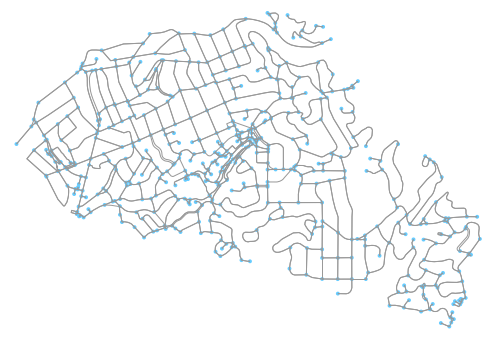

In [13]:
G = ox.graph_from_place('Piedmont, California, USA')
fig, ax = ox.plot_graph(G)

In [15]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=False,
                                             fill_edge_geometry=False)

In [16]:
gdf_nodes.head()

,highway,osmid,x,y
4679800850,crossing,4679800850,-122.247032,37.823893
2063061010,crossing,2063061010,-122.245839,37.822546
53090322,NaN,53090322,-122.236803,37.820424
53090323,NaN,53090323,-122.236571,37.820203
2063061015,NaN,2063061015,-122.244742,37.822475


In [22]:
gdf_edges.head()

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,service,u,v
0,NaN,NaN,NaN,residential,NaN,0,NaN,9.569,NaN,Lake Avenue,False,6327300,NaN,4679800850,53018411
1,NaN,NaN,"LINESTRING (-122.2470324 37.8238928, -122.2478...",residential,NaN,0,NaN,105.523,NaN,Lake Avenue,False,6327300,NaN,4679800850,53018410
2,NaN,NaN,"LINESTRING (-122.2470324 37.8238928, -122.2468...",footway,NaN,0,NaN,95.032,NaN,NaN,False,"[665736753, 665736755]",NaN,4679800850,310714439
3,NaN,NaN,NaN,tertiary,NaN,0,NaN,45.979,NaN,Linda Avenue,False,196739937,NaN,2063061010,6231542430
4,NaN,NaN,NaN,footway,NaN,0,NaN,7.839,NaN,NaN,False,665736110,NaN,2063061010,6231544507


In [ ]:
gdf_edges.applymap(str).dtypes